# **Collaborative Filtering Method (Item- User) _ Finding Similar Items**

# Introduction:

For the collaborative filtering model, we frist make the matrix of users and items interactions which contains 0 and 1. Here we need to normalize these values in order to caculate the item or user similarities.

In [1]:
#import needed libraries and connecting to google drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Loading the Data

In [2]:
#reading the transaction csv file
transaction=pd.read_csv('D:/Datasciencebootcamp/Capstone/Submission/transaction.csv')

In [3]:
#checking the head
transaction.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [4]:
#checking shape of dataset
transaction.shape

(28813419, 5)

28,813,419 rows and 5 columns

# Changing columns types

Due to memory issues I will change the data types in order to reserve less memory.

In [5]:
transaction['customer_id'] =\
    transaction['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [6]:
transaction['article_id'] = transaction['article_id'].astype('int32')

In [7]:
#sanity check
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28813419 entries, 0 to 28813418
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       int64  
 2   article_id        int32  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 989.2+ MB


I will define a function to get the transactions between specific dates because the dataset is huge and can not run the model on this huge file.

# Defining a query Function

In [8]:
#the input is the dataframe, startdate and end date
def query_date(df, start_date='2019-09-01', end_date='2020-09-22'):
    x = df[(df['t_dat']>start_date) & (df['t_dat']<=end_date)]
    return x

In [9]:
#Let's work on the query in October 2019 

start_date = '2019-10-01'
x = query_date(transaction, start_date,'2019-10-02')

In [10]:
#sanity check
x.head()

,t_dat,customer_id,article_id,price,sales_channel_id
15724693,2019-10-02,-2477030216582433370,738133005,0.016932,2
15724694,2019-10-02,-2477030216582433370,680265002,0.042356,2
15724695,2019-10-02,-2477030216582433370,740962001,0.042356,2
15724696,2019-10-02,-7676380718319476240,661794002,0.059305,2
15724697,2019-10-02,-7676380718319476240,556528009,0.020322,2


In [11]:
#dropping the unused columns in this model
x= x.drop(['t_dat','price', 'sales_channel_id'],axis=1)

In [12]:
#checking the shape
x.shape

(57066, 2)

In [13]:
#checking the head
x.head()

,customer_id,article_id
15724693,-2477030216582433370,738133005
15724694,-2477030216582433370,680265002
15724695,-2477030216582433370,740962001
15724696,-7676380718319476240,661794002
15724697,-7676380718319476240,556528009


In [14]:
x['customer_id'].unique

<bound method Series.unique of 15724693   -2477030216582433370
15724694   -2477030216582433370
15724695   -2477030216582433370
15724696   -7676380718319476240
15724697   -7676380718319476240
                   ...         
15781754   -1659733796898509111
15781755   -1659733796898509111
15781756   -5857876721660219842
15781757    1580613162624139941
15781758    1580613162624139941
Name: customer_id, Length: 57066, dtype: int64>

# Preparing Train Dataset

In [15]:
#We will groupby the customer id and article ids because We want to check whether a customer has purchased
#the item or not and by doing this we will remove the duplicates
x=x.groupby(['customer_id','article_id']).agg('sum').reset_index()

In [16]:
#adding a dummies column for the purchased items (1 for all the purchased ones)
x['Bought'] = 1

In [17]:
x

,customer_id,article_id,Bought
0,-9222743362869058469,533404010,1
1,-9222743362869058469,649098003,1
2,-9222743362869058469,669522006,1
3,-9222743362869058469,724979001,1
4,-9222743362869058469,736102002,1
...,...,...,...
56783,9217538700961510539,762143002,1
56784,9217538700961510539,801673001,1
56785,9217538700961510539,811198002,1
56786,9220710538849073210,456163065,1


In order to work on the collaborative model I shoul pivot the dataframe to see the data like below. In which the index is customer ids and columns are article ids.

In [18]:
#in pivot function the values are the dummies in case a customer bought the items there is 1 but if not 
#there in NAN so I will fill the na values with 0.
df = x.pivot_table(index = 'customer_id', columns ='article_id', values = 'Bought').fillna(0)
#sanity check
df

article_id,110065001,110065002,111565001,111586001,111593001,111609001,120129001,120129014,120129025,123173001,...,840235001,840906001,843246002,843540001,843545001,844915002,845541001,845854001,846592001,848327001
customer_id,,,,,,,,,,,,,,,,,,,,,
-9222743362869058469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9220764285218633454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9220763195108524050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9220392800842515209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9219651110091199244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9212131828065180491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9212208121748780553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9215865051452698487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#checking the columns which are the item ids
df.columns

Int64Index([110065001, 110065002, 111565001, 111586001, 111593001, 111609001,
            120129001, 120129014, 120129025, 123173001,
            ...
            840235001, 840906001, 843246002, 843540001, 843545001, 844915002,
            845541001, 845854001, 846592001, 848327001],
           dtype='int64', name='article_id', length=11953)

In [20]:
#checking the index which is the customer ids
df.index

Int64Index([-9222743362869058469, -9220764285218633454, -9220763195108524050,
            -9220392800842515209, -9219651110091199244, -9219601184804537202,
            -9218424504481778459, -9218353488831051343, -9218069445180624751,
            -9217503830593059665,
            ...
             9207859852139690416,  9208097125269245463,  9208550150071112988,
             9210750755749784919,  9211033256540884205,  9212131828065180491,
             9212208121748780553,  9215865051452698487,  9217538700961510539,
             9220710538849073210],
           dtype='int64', name='customer_id', length=17246)

In [21]:
#resetting the index because later we do not need coustomer column
df_resetted = df.reset_index().rename_axis(None, axis=1) 

df_resetted

,customer_id,110065001,110065002,111565001,111586001,111593001,111609001,120129001,120129014,120129025,...,840235001,840906001,843246002,843540001,843545001,844915002,845541001,845854001,846592001,848327001
0,-9222743362869058469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-9220764285218633454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-9220763195108524050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-9220392800842515209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-9219651110091199244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17241,9212131828065180491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17242,9212208121748780553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17243,9215865051452698487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17244,9217538700961510539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#sanity check
df_resetted.columns

Index(['customer_id',     110065001,     110065002,     111565001,
           111586001,     111593001,     111609001,     120129001,
           120129014,     120129025,
       ...
           840235001,     840906001,     843246002,     843540001,
           843545001,     844915002,     845541001,     845854001,
           846592001,     848327001],
      dtype='object', length=11954)

In [23]:
#sanity check
df_resetted.index

RangeIndex(start=0, stop=17246, step=1)

In [24]:
#dropping the customer id collumn
purchase_Item = df_resetted.drop("customer_id", 1) 

C:\Users\molla\AppData\Local\Temp\ipykernel_8360\3220593295.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  purchase_Item = df_resetted.drop("customer_id", 1)


In [25]:
#sanity check
purchase_Item.head()

,110065001,110065002,111565001,111586001,111593001,111609001,120129001,120129014,120129025,123173001,...,840235001,840906001,843246002,843540001,843545001,844915002,845541001,845854001,846592001,848327001
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Normalizing the Dataset

**I will normalize dataframe for comparising reasons:**

# Source: Different ways of normalization: https://www.geeksforgeeks.org/how-to-normalize-an-numpy-array-so-the-values-range-exactly-between-0-and-1/

In [26]:

purchase_Item_Norm = purchase_Item/np.sqrt(np.square(purchase_Item).sum(axis=0))   
purchase_Item_Norm.head(10)

,110065001,110065002,111565001,111586001,111593001,111609001,120129001,120129014,120129025,123173001,...,840235001,840906001,843246002,843540001,843545001,844915002,845541001,845854001,846592001,848327001
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Finding Similar Items based on collaborative filtering

In [27]:
#Calculating with .dot Vectors to compute Cosine Similarities:

ItemItemSim = purchase_Item_Norm.transpose().dot(purchase_Item_Norm)
ItemItemSim.head(10)

,110065001,110065002,111565001,111586001,111593001,111609001,120129001,120129014,120129025,123173001,...,840235001,840906001,843246002,843540001,843545001,844915002,845541001,845854001,846592001,848327001
110065001,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110065002,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111565001,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111586001,0.0,0.0,0.0,1.000000,0.229786,0.0,0.0,0.0,0.0,0.102062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111593001,0.0,0.0,0.0,0.229786,1.000000,0.0,0.0,0.0,0.0,0.107211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111609001,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120129001,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120129014,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120129025,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123173001,0.0,0.0,0.0,0.102062,0.107211,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#creating a place holder for similar items
ItemNeighbours = pd.DataFrame(index=ItemItemSim.columns,columns=range(1,11))
ItemNeighbours.head()

,1,2,3,4,5,6,7,8,9,10
110065001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110065002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111565001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111586001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111593001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#filling the itemneighbors table form the similarity table 
#first sorting the similarity scores and then fill in the top 9
for i in range(0,len(ItemItemSim.columns)): 
    ItemNeighbours.iloc[i,:10] = ItemItemSim.iloc[0:,i].sort_values(ascending=False)[:10].index 
  #we only have 9 items, so we can max recommend 9 items (itself included) 

C:\Users\molla\AppData\Local\Temp\ipykernel_8360\407603306.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ItemNeighbours.iloc[i,:10] = ItemItemSim.iloc[0:,i].sort_values(ascending=False)[:10].index


In [30]:
#sanity check
ItemNeighbours.head()

,1,2,3,4,5,6,7,8,9,10
110065001,110065001,754267014,707488001,675070015,611415024,681175003,704720008,675070013,777273005,794791001
110065002,110065002,736923002,699110001,759814011,759814009,755869001,755869002,755872001,755876002,755876005
111565001,111565001,700910001,559634006,772829002,781758003,611415001,228257001,779862001,759465001,809230001
111586001,111586001,457466002,111593001,653275005,669786001,757151005,757151001,741220012,436261001,671607001
111593001,111593001,111586001,563635001,653275005,158340001,436261001,457466001,762313003,736923004,716590001


In [31]:
ItemNeighbours.head().iloc[:11,1:10]

,2,3,4,5,6,7,8,9,10
110065001,754267014,707488001,675070015,611415024,681175003,704720008,675070013,777273005,794791001
110065002,736923002,699110001,759814011,759814009,755869001,755869002,755872001,755876002,755876005
111565001,700910001,559634006,772829002,781758003,611415001,228257001,779862001,759465001,809230001
111586001,457466002,111593001,653275005,669786001,757151005,757151001,741220012,436261001,671607001
111593001,111586001,563635001,653275005,158340001,436261001,457466001,762313003,736923004,716590001


# Defining a Recommendation System

## ** we will have a look which items our customers have bought and get the top N neighbours for each item. Afterwards we calculate the purchase history of the customer for each neighbour and calculate a similarity score for them. So in the end we just have to recommend the items with the highest score. Therefore we will create a place holder matrix for similarities, and fill in the customer column:**

In [ ]:
#Therefore we will create a place holder matrix for similarities, and fill in the customer column:
#Let's assume we want to recommend to 10 customers
CustomerItemSimilarity = pd.DataFrame(index=df_resetted.index[:10],columns=df_resetted.columns)
CustomerItemSimilarity.iloc[:,0] = df_resetted.iloc[0:10,0]
CustomerItemSimilarity

We'll define a set of items similar to  𝑚  that user  𝑢  purchased. We can take the average rating(normalized purchase) for each item in this list and use it as the value for  𝑅𝑢𝑚 .𝐶  is the number of total items:

**We rate items that the customer has already bought as 0, because there is no point in recommending those again.**

In [33]:
#We will calculate the prediction score
def getScore(history, similarities):
    R= np.dot(history, similarities)/np.sum(similarities)
    return R

In [ ]:


#the first for go over customer ids
for i in range(0,len(CustomerItemSimilarity.index)):
  #the second for loop goes over the item ids
    for j in range(1,len(CustomerItemSimilarity.columns)):
        user = CustomerItemSimilarity.index[i]
        product = CustomerItemSimilarity.columns[j]
 #we don't want to recomment the items that customer has already purchased so we put 0 there
        if df_resetted.iloc[i,j] == 1:
            CustomerItemSimilarity.iloc[i,j] = 0
        else:
            #first pick the first 9 items with highest similarity to the item
            ItemTop = ItemNeighbours.loc[product,1:10]

            #sort the items based on similarity score
            ItemTopSimilarity =ItemItemSim.loc[product].sort_values(ascending=False)[1:11]

            #here we will use the item dataframe, which we generated during item-item matrix 
            CustomerPurchasings =purchase_Item.loc[user,ItemTop]
            
            #now we have the history of customer's purchases and the similarity scores of the top similar items
            #so we can fill the prediction score table
            CustomerItemSimilarity.iloc[i,j] = getScore(CustomerPurchasings,ItemTopSimilarity)



There is some nan values for some items that's why we got Runetime warning. There is not similar items for all items in this sample.

In [35]:
CustomerItemSimilarity

,customer_id,110065001,110065002,111565001,111586001,111593001,111609001,120129001,120129014,120129025,...,840235001,840906001,843246002,843540001,843545001,844915002,845541001,845854001,846592001,848327001
0,-9222743362869058469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
1,-9220764285218633454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
2,-9220763195108524050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
3,-9220392800842515209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
4,-9219651110091199244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
5,-9219601184804537202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
6,-9218424504481778459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
7,-9218353488831051343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
8,-9218069445180624751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
9,-9217503830593059665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0


Instead of having the matrix filled with similarity scores we want to see the top product names. Therefore loop:

In [36]:
#first we create the place holder
CustItemRecommend = pd.DataFrame(index=CustomerItemSimilarity.index, columns=['customer','1','2','3','4','5','6','7','8','9'])
 #Top 1,2..,9 

#check
CustItemRecommend.head()


,customer,1,2,3,4,5,6,7,8,9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#then for all of our customers we will fill in the table with the top similarity scores  which we predict before
for i in range(0,len(CustomerItemSimilarity.index)): 
  CustItemRecommend.iloc[i,1:] = CustomerItemSimilarity.iloc[i,:].sort_values(ascending=False).iloc[1:10,].index.transpose() 

  
CustItemRecommend.head()

,customer,1,2,3,4,5,6,7,8,9
0,NaN,533404019,554450026,768931001,495685001,740412001,721085001,449570018,801252002,696125001
1,NaN,752002002,736870001,727612001,755610001,755610004,755616001,755626001,755631008,755644002
2,NaN,701244002,700737010,633347003,759465004,749885001,619884001,717816003,749177002,764073004
3,NaN,771368002,680811002,711188001,623146001,790666001,767983002,801384004,718727001,381038026
4,NaN,720804002,399256005,535826006,784384003,642910010,727612001,755686001,755609002,755610001


In [38]:
#fill in customer column
CustItemRecommend['customer']=CustomerItemSimilarity['customer_id']

In [39]:
#check
CustItemRecommend

,customer,1,2,3,4,5,6,7,8,9
0,-9222743362869058469,533404019,554450026,768931001,495685001,740412001,721085001,449570018,801252002,696125001
1,-9220764285218633454,752002002,736870001,727612001,755610001,755610004,755616001,755626001,755631008,755644002
2,-9220763195108524050,701244002,700737010,633347003,759465004,749885001,619884001,717816003,749177002,764073004
3,-9220392800842515209,771368002,680811002,711188001,623146001,790666001,767983002,801384004,718727001,381038026
4,-9219651110091199244,720804002,399256005,535826006,784384003,642910010,727612001,755686001,755609002,755610001
5,-9219601184804537202,727612001,755780002,755609002,755610001,755610004,755616001,755626001,755631008,755644002
6,-9218424504481778459,732409010,577512008,755696004,755609002,755610001,755610004,755616001,755626001,755631008
7,-9218353488831051343,755781001,755609002,755610001,755610004,755616001,755626001,755631008,755644002,755686001
8,-9218069445180624751,765739005,787696001,789262001,761713003,556438014,726228001,710397003,755686001,755610004
9,-9217503830593059665,598515022,598755003,727612001,755733001,755616001,755626001,755631008,755644002,755686001


In [49]:
#check recommendation for one customer
Rec1=list(CustItemRecommend.iloc[0,1:10])
Rec1

[533404019,
 554450026,
 768931001,
 495685001,
 740412001,
 721085001,
 449570018,
 801252002,
 696125001]

In [50]:
images_dir = 'D:/images'

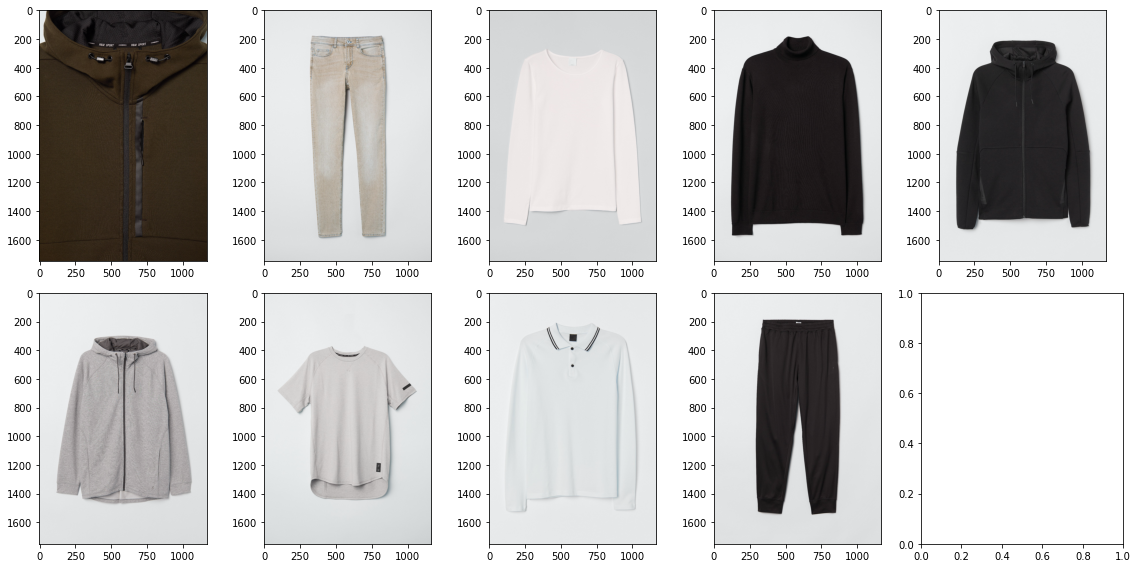

In [51]:
#showing the images of recommendation for user index 3
figure, ax = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
for iid, im_id in enumerate(Rec1):

    #that's how the image path is in my directory
        image_path = f'{images_dir}/0{str(im_id)[:2]}/0{im_id}.jpg'
        
        #using cv2 to read the image
        image=cv2.imread(image_path)
        
        try:
            #flatten it and then show it
            ax.ravel()[iid].imshow(image)
            
        except:
            continue;
            
#first plotting the layout of images            
plt.tight_layout()

#showing the whole set of images
plt.show()

#I first tried the first 8 lines of the code 

Not all the items have images.

In [52]:
#purchase history of this customer
test=x[x['customer_id']==-9222743362869058469]

In [53]:
test=test['article_id']

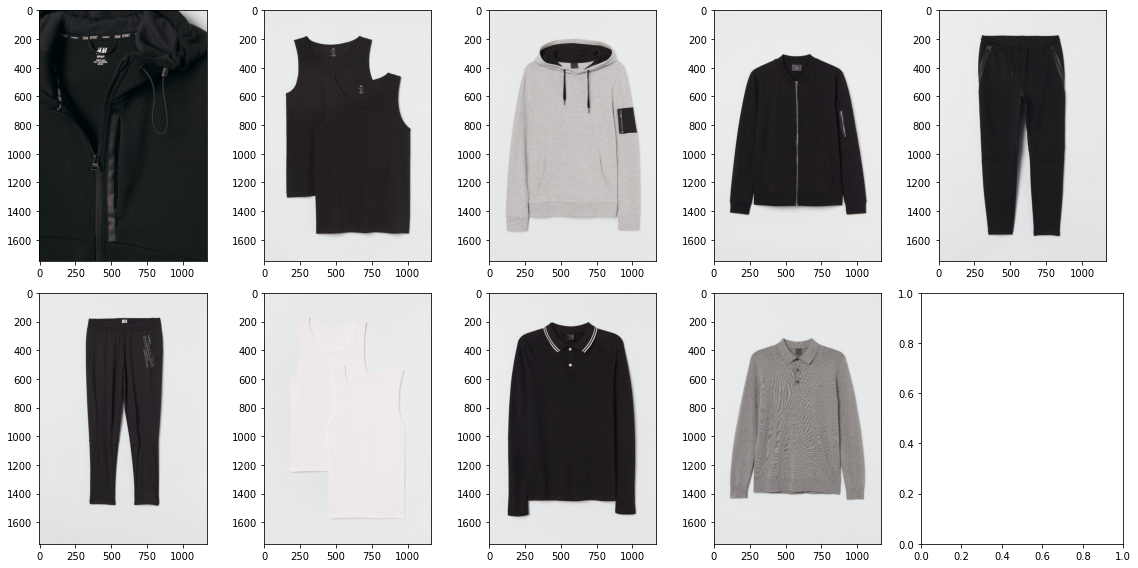

In [54]:
figure, ax = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
for iid, im_id in enumerate(test):

    #that's how the image path is in my directory
        image_path = f'{images_dir}/0{str(im_id)[:2]}/0{im_id}.jpg'
        
        #using cv2 to read the image
        image=cv2.imread(image_path)
        
        try:
            #flatten it and then show it
            ax.ravel()[iid].imshow(image)
            
        except:
            continue;
            
#first plotting the layout of images            
plt.tight_layout()

#showing the whole set of images
plt.show()

# Result: 

By checking a random customer purchase history and comparing with the evaluation we can come to conclusion that the recommendation function based on item-item similarity works well enough. As you can see the items are so relatable.

This approach is based on https://towardsdatascience.com/recommender-systems-item-customer-collaborative-filtering-ff0c8f41ae8a article.